In [3]:
import numpy as np

from commons import *
from dgl.nn.pytorch import GATConv, EdgeConv

In [6]:
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32

def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCNSoftmax(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

def partition_weight(adj, s):
    """
    Calculates the sum of weights of edges that are in different partitions.

    :param adj: Adjacency matrix of the graph.
    :param s: List indicating the partition of each edge (0 or 1).
    :return: Sum of weights of edges in different partitions.
    """
    s = np.array(s)
    partition_matrix = np.not_equal.outer(s, s).astype(int)
    weight = (adj * partition_matrix).sum() / 2
    return weight

def calculateAllCut(q_torch, s):
    '''

    :param q_torch: The adjacent matrix of the graph
    :param s: The binary output from the neural network. s will be in form of [[prob1, prob2, ..., prob n], ...]
    :return: The calculated cut loss value
    '''
    if len(s) > 0:
        totalCuts = len(s[0])
        CutValue = 0
        for i in range(totalCuts):
            CutValue += partition_weight(q_torch, s[:,i])
        return CutValue/2
    return 0


def printCombo(orig):
    # Original dictionary
    input_dict = orig

    # Generate all permutations of the dictionary values
    value_permutations = list(permutations(input_dict.values()))

    # Create a list of dictionaries from the permutations
    permuted_dicts = [{key: value for key, value in zip(input_dict.keys(), perm)} for perm in value_permutations]

    return permuted_dicts

def GetOptimal(net, dgl_graph, inp, q_torch, terminal = None):

    probs = net(dgl_graph, inp, terminal)
    binary_partitions = (probs >= 0.5).float()

    for i in range(len(binary_partitions)-1):
        if torch.sum(binary_partitions[i]) != 1:
            binary_partitions[i] = torch.tensor([0,1,0])

    cut_value_item = calculateAllCut(q_torch, binary_partitions)

    return cut_value_item, binary_partitions

def GetOptimalNetValue(net, dgl_graph, inp, q_torch, terminal_dict):
    net.eval()
    best_loss = float('inf')
    best_binary = []
    # if (dgl_graph.number_of_nodes() < 30):
    #     inp = torch.ones((dgl_graph.number_of_nodes(), 30))

    # find all potential combination of terminal nodes with respective indices

    perm_items = printCombo(terminal_dict)
    for i in perm_items:
        probs = net(dgl_graph, inp, i)
        binary_partitions = (probs >= 0.5).float()
        # print([m for m in binary_partitions if sum(m)>1 or sum(m)==0])
        # print(binary_partitions, q_torch)
        cut_value_item = calculateAllCut(q_torch, binary_partitions)
        if cut_value_item < best_loss:
            best_loss = cut_value_item
            best_binary = binary_partitions
    return best_loss, best_binary

In [11]:

def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 80    # e.g. 10
    hidden_dim = int(dim_embedding/2)
    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

In [4]:
def test1(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')
    # test_item_2 = {}
    # test_item_2[0]=test_item[1]
    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():
        # embed = nn.Embedding(graph.number_of_nodes(), dim_embedding)
        # embed = embed.type(TORCH_DTYPE).to(TORCH_DEVICE)
        # inputs = embed.weight
        #inputs = model.embed.weight
        # cut_val, partition = GetOptimal(model,dgl_graph, inputs, adjacency_matrix, {terminal[0]:0, terminal[1]:1, terminal[2]:2})
        # neural_cut.append(cut_val)
        print(inputs, inputs.size())
        logits = net(dgl_graph, inputs)
        binary_partitions = (logits >= 0.5).float()

        # for i in range(len(binary_partitions)-1):
        #     if torch.sum(binary_partitions[i]) != 1:
        #         binary_partitions[i] = torch.tensor([1,0,0])

        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        # cut_value, (part_1, part_2) = nx.minimum_cut(test_item_2[0][2], test_item_2[0][3][1], test_item_2[0][3][0], flow_func=shortest_augmenting_path)

        print("Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break


In [ ]:
test1('./final__80wayCut_LossOrig.pth')

In [ ]:
test1('./final__80wayCut_LossMinCut.pth')


In [ ]:
test1('./final__80wayCut_LossNew.pth')


In [ ]:
test1('./final__80wayCut_Losscomb.pth')


In [ ]:
test1('./final__80wayCut_Lossinter.pth')


In [ ]:
test1('./final__80wayCut_Lossinter_min_cut_loss.pth')





In [ ]:
test1('./final__80wayCut_Lossinter_min_cut_loss.pth')


In [ ]:
test1('./final__80wayCut_Lossinter_min_cut_loss_2.pth')

In [ ]:
test1('./final__80wayCut_Lossinter_min_cut_loss_3.pth')


In [ ]:
test1('./final__80wayCut_Lossinter_min_cut_loss_4.pth')


In [ ]:
test1('./final__80wayCut_Lossinter_min_cut_loss_5.pth')


In [ ]:
test1('./final__80wayCut_Lossinter_min_cut_loss_6.pth')


In [ ]:
test1('./final__80wayCut_Lossinter_min_cut_loss_7.pth')


In [ ]:
#with no terminal loss
test1('./final__80wayCut_Lossinter_min_cut_loss_9.pth')


In [ ]:
# with terminal loss
test1('./final__80wayCut_Lossinter_min_cut_loss_9.pth')


In [ ]:
# with terminal loss in NN
test1('./final__80wayCut_Lossinter_min_cut_loss_9.pth')


In [ ]:
# with terminal loss in NN
test1('./final__80wayCut_Lossinter_min_cut_loss_9.pth')


In [ ]:
# with terminal loss in NN
test1('./final__80wayCut_Lossinter_min_cut_loss_9.pth')


In [5]:
def test2(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')
    # test_item_2 = {}
    # test_item_2[0]=test_item[1]
    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():
        # embed = nn.Embedding(graph.number_of_nodes(), dim_embedding)
        # embed = embed.type(TORCH_DTYPE).to(TORCH_DEVICE)
        # inputs = embed.weight
        #inputs = model.embed.weight
        # cut_val, partition = GetOptimal(model,dgl_graph, inputs, adjacency_matrix, {terminal[0]:0, terminal[1]:1, terminal[2]:2})
        # neural_cut.append(cut_val)
        # print(inputs, inputs.size())
        logits = net(dgl_graph, adjacency_matrix)
        binary_partitions = (logits >= 0.5).float()

        # for i in range(len(binary_partitions)-1):
        #     if torch.sum(binary_partitions[i]) != 1:
        #         binary_partitions[i] = torch.tensor([1,0,0])

        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        # cut_value, (part_1, part_2) = nx.minimum_cut(test_item_2[0][2], test_item_2[0][3][1], test_item_2[0][3][0], flow_func=shortest_augmenting_path)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break


In [51]:
test2('./final__80wayCut_LossOrig_2.pth')


Neural 3-way min-cut value: tensor(672., dtype=torch.float64) 7.0 11.0 62.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(277., dtype=torch.float64) 9.0 5.0 66.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 0., 1.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(498., dtype=torch.float64) 5.0 6.0 69.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(216., dtype=torch.float64) 9.0 6.0 65.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([0., 1., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(202., dtype=torch.float64) 9.0 15.0 56.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes

In [54]:
test2('./final__80wayCut_Lossinter_min_cut_loss_9_new.pth')


Neural 3-way min-cut value: tensor(321., dtype=torch.float64) 38.0 0.0 42.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(37., dtype=torch.float64) 32.0 0.0 48.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(102., dtype=torch.float64) 25.0 0.0 55.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 0., 1.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(135., dtype=torch.float64) 31.0 0.0 49.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 0., 1.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(384., dtype=torch.float64) 23.0 0.0 57.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([0., 0., 1.])2-tensor([0., 0., 1.])
Invalids Nod

In [56]:
test2('./final__80wayCut_Lossinter_min_cut_loss_10_new.pth')


Neural 3-way min-cut value: tensor(629., dtype=torch.float64) 51.0 21.0 8.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1., 0.]) 1-tensor([1., 0., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(565., dtype=torch.float64) 69.0 5.0 6.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(734., dtype=torch.float64) 61.0 18.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1., 0.]) 1-tensor([0., 0., 1.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(525., dtype=torch.float64) 56.0 21.0 3.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(252., dtype=torch.float64) 49.0 16.0 15.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids No

In [57]:
test2('./final__80wayCut_Lossinter_min_cut_loss_10_new.pth')


Neural 3-way min-cut value: tensor(653., dtype=torch.float64) 76.0 2.0 2.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([0., 1., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(10., dtype=torch.float64) 71.0 0.0 9.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(338., dtype=torch.float64) 75.0 4.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(206., dtype=torch.float64) 71.0 7.0 2.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(47., dtype=torch.float64) 72.0 0.0 8.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0


In [59]:
test2('./final__80wayCut_Lossinter_min_cut_loss_10_new.pth')


0 : number : Neural 3-way min-cut value: tensor(653., dtype=torch.float64) 76.0 2.0 2.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([0., 1., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(10., dtype=torch.float64) 71.0 0.0 9.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(338., dtype=torch.float64) 75.0 4.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(206., dtype=torch.float64) 71.0 7.0 2.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(47., dtype=torch.float64) 62.0 10.0 8.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.

In [62]:
test2('./final__80wayCut_LossOrig_2.pth')

0 : number : Neural 3-way min-cut value: tensor(338., dtype=torch.float64) 14.0 39.0 27.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1., 0.]) 1-tensor([1., 0., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(84., dtype=torch.float64) 7.0 55.0 18.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1., 0.]) 1-tensor([0., 0., 1.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(478., dtype=torch.float64) 15.0 39.0 26.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(604., dtype=torch.float64) 8.0 44.0 28.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(270., dtype=torch.float64) 13.0 44.0 23.0 Total Nodes:80.0
Terminalss: 0-tensor([0.

### Associated with Exp2
Removing terminal penalty, now using cloning


In [11]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp2(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp2('./final__80wayCut_LossExp2.pth')

0 : number : Neural 3-way min-cut value: tensor(130., dtype=torch.float64) 70.0 6.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(12., dtype=torch.float64) 70.0 6.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(50., dtype=torch.float64) 72.0 4.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(200., dtype=torch.float64) 72.0 3.0 5.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(70., dtype=torch.float64) 70.0 5.0 5.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.])

## Associated with Exp1 - loss
modified loss with terminal loss

In [13]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        # logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp1_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(653., dtype=torch.float64) 56.0 6.0 18.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([0., 1., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(157., dtype=torch.float64) 69.0 1.0 10.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(619., dtype=torch.float64) 60.0 12.0 8.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1., 0.]) 1-tensor([1., 0., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(224., dtype=torch.float64) 53.0 15.0 12.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(118., dtype=torch.float64) 55.0 16.0 9.0 Total Nodes:80.0
Terminalss: 0-tensor([0.,

## Associated with Exp2 - loss
modified loss with fixed terminal loss (using clone)

In [14]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp2_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(559., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(262., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(338., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(498., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(429., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0

## Exp3
using binary loss

In [17]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        # logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp3_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(441., dtype=torch.float64) 12.0 5.0 63.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1., 0.]) 1-tensor([1., 0., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(134., dtype=torch.float64) 1.0 8.0 71.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1., 0.]) 1-tensor([0., 0., 1.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(375., dtype=torch.float64) 1.0 5.0 74.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([0., 1., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(218., dtype=torch.float64) 1.0 8.0 71.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(299., dtype=torch.float64) 1.0 10.0 69.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1.,

## Exp4
binary loss function with fixed penality

In [18]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp4_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(429., dtype=torch.float64) 75.0 1.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(150., dtype=torch.float64) 75.0 1.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(171., dtype=torch.float64) 75.0 1.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(345., dtype=torch.float64) 74.0 1.0 5.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(177., dtype=torch.float64) 75.0 1.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0

## Exp 5 - loss
Changing the loss function to intake binary input and find exact loss value +  loss function

In [19]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp5_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(127., dtype=torch.float64) 5.0 71.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(28., dtype=torch.float64) 8.0 68.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(60., dtype=torch.float64) 7.0 69.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(210., dtype=torch.float64) 5.0 72.0 3.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(133., dtype=torch.float64) 7.0 68.0 5.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]

## Exp 6 - loss
Changing the loss function to intake binary input and find exact loss value +  loss function + terminal loss

In [21]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        # logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp6_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(472., dtype=torch.float64) 10.0 4.0 66.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 0., 1.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(129., dtype=torch.float64) 1.0 8.0 71.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1., 0.]) 1-tensor([0., 0., 1.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(302., dtype=torch.float64) 1.0 12.0 67.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 0., 1.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(430., dtype=torch.float64) 7.0 12.0 61.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([0., 1., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(399., dtype=torch.float64) 1.0 16.0 63.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0

## Exp 7 - loss
Changing the loss function to intake binary input and find exact loss value +  loss function

In [24]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./epoch300loss31906.0_80wayCut_LossExp7_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(130., dtype=torch.float64) 69.0 6.0 5.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(12., dtype=torch.float64) 70.0 6.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(49., dtype=torch.float64) 73.0 3.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(200., dtype=torch.float64) 72.0 3.0 5.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(70., dtype=torch.float64) 70.0 5.0 5.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.])

## Exp 8 - loss (2 - way cut)
Changing the loss function to intake binary input and find exact loss value +  loss function

In [26]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0])
    # Set the output for node 2 to [0, 0, 1]
    # output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 2,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp8_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(130., dtype=torch.float64) 74.0 6.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0.]) 1-tensor([0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(14., dtype=torch.float64) 73.0 7.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0.]) 1-tensor([0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(33., dtype=torch.float64) 76.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0.]) 1-tensor([0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(128., dtype=torch.float64) 77.0 3.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0.]) 1-tensor([0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(25., dtype=torch.float64) 75.0 5.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0.]) 1-tensor([0., 1.])
Invalids Nodes: 0
---------- 

5 : number : Neural 3-way min-cut value: tensor(81., dtype=torch.float64) 76.0 4.0 Total Node

## Exp 9
Adding HA and HC, removing terminal loss

In [27]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp9_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(166., dtype=torch.float64) 5.0 6.0 69.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(28., dtype=torch.float64) 8.0 6.0 66.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(57., dtype=torch.float64) 7.0 4.0 69.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(176., dtype=torch.float64) 5.0 3.0 72.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(113., dtype=torch.float64) 7.0 5.0 68.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]

## Exp 10
Adding HA and HC, keeping terminal loss

In [28]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        # logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp10_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(978., dtype=torch.float64) 59.0 15.0 6.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(285., dtype=torch.float64) 71.0 5.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([0., 1., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(250., dtype=torch.float64) 67.0 5.0 8.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([1., 0., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(677., dtype=torch.float64) 56.0 12.0 12.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 0., 1.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(302., dtype=torch.float64) 62.0 1.0 17.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0

## Exp 11
Adding HC, and node balancing loss

In [29]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0])
    # Set the output for node 2 to [0, 0, 1]
    # output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 2,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp11_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(429., dtype=torch.float64) 79.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0.]) 1-tensor([0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(144., dtype=torch.float64) 79.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0.]) 1-tensor([0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(154., dtype=torch.float64) 79.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0.]) 1-tensor([0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(203., dtype=torch.float64) 79.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0.]) 1-tensor([0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(150., dtype=torch.float64) 79.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0.]) 1-tensor([0., 1.])
Invalids Nodes: 0
---------- 

5 : number : Neural 3-way min-cut value: tensor(246., dtype=torch.float64) 79.0 1.0 Total 

## Exp 12

- expriment 6 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- keeping terminal loss
- Using GATCOnv as base neural network


In [16]:
def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCNSoftmax(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GATConv(in_feats, hidden_size, num_heads=1).to(device)
        self.conv2 = GATConv(hidden_size, num_classes, num_heads=1).to(device)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs).squeeze(1)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h).squeeze(1)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp12_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(131., dtype=torch.float64) 69.0 7.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(20., dtype=torch.float64) 69.0 7.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(50., dtype=torch.float64) 72.0 4.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(270., dtype=torch.float64) 73.0 3.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(52., dtype=torch.float64) 71.0 5.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.])

## Exp 13

- expriment 6 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- keeping terminal loss
- Using Graph conv as base neural network


In [17]:
def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCNSoftmax(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h


def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        dgl_graph.ndata['feat'] = adjacency_matrix
        logits = net(dgl_graph, dgl_graph.ndata['feat'])
        logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()

        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp13_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(166., dtype=torch.float64) 5.0 6.0 69.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(40., dtype=torch.float64) 10.0 7.0 63.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(57., dtype=torch.float64) 7.0 4.0 69.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(176., dtype=torch.float64) 5.0 3.0 72.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(113., dtype=torch.float64) 7.0 5.0 68.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.

## Exp 14

- expriment 6 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- keeping terminal loss
- Using Graph conv as base neural network, adding ndata attribute with more node related information


In [18]:
def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCNSoftmax(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, hidden_size).to(device)
        self.conv3 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv3(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h


def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        dgl_graph.ndata['feat'] = adjacency_matrix
        logits = net(dgl_graph, dgl_graph.ndata['feat'])
        logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()

        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp14_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(434., dtype=torch.float64) 1.0 78.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(467., dtype=torch.float64) 1.0 78.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(471., dtype=torch.float64) 1.0 78.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(582., dtype=torch.float64) 1.0 78.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(584., dtype=torch.float64) 1.0 78.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0

# Exp 15

In [9]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = EdgeConv(in_feats, hidden_size).to(device)
        self.conv2 = EdgeConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

In [11]:
def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCNSoftmax(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = EdgeConv(in_feats, hidden_size).to(device)
        self.conv2 = EdgeConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp12_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(130., dtype=torch.float64) 70.0 6.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(11., dtype=torch.float64) 71.0 5.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(49., dtype=torch.float64) 73.0 3.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(274., dtype=torch.float64) 74.0 2.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(49., dtype=torch.float64) 70.0 6.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.])

In [7]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output


test2('./final__80wayCut_LossExp1.pth')

0 : number : Neural 3-way min-cut value: tensor(559., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(262., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(338., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(498., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(429., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0

## Exp 16

- expriment 16 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss
- training on dataset with 8Experiment 16

(None,
 tensor([[0., 1., 1., 1., 0., 0., 0., 0.],
         [1., 0., 1., 1., 0., 0., 0., 0.],
         [1., 1., 0., 1., 0., 0., 0., 0.],
         [1., 1., 1., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 1., 1., 1.],
         [0., 0., 0., 0., 1., 0., 1., 1.],
         [0., 0., 0., 0., 1., 1., 0., 1.],
         [0., 0., 0., 0., 1., 1., 1., 0.]]),
 {'capacity': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1,
         1, 1])})

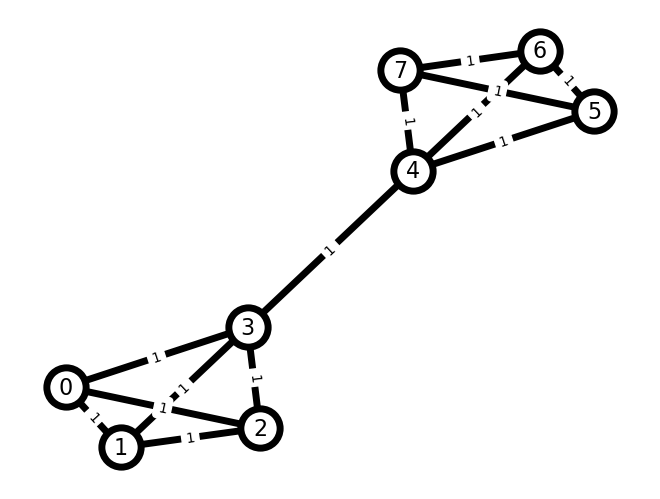

In [69]:
def CreateDummyFunction(edges):
    test_graph = nx.Graph()
    test_graph.add_edges_from(edges)
    test_graph.order()
    return test_graph

def DrawGraph(graph, color_map="white"):
    pos = nx.spring_layout(graph,seed=1)

    # Visualize graph
    options = {
        "font_size": 16,
        "node_size": 800,
        "node_color": color_map,
        "edgecolors": "black",
        "linewidths": 5,
        "width": 5,
    }
    nx.draw(graph, pos, with_labels=True, **options)

    labels = nx.get_edge_attributes(graph,'weight')
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)

edges = [
    (0, 1, {"weight": 1, "capacity": 1}),
    (0, 2, {"weight": 1, "capacity": 1}),
    (0, 3, {"weight": 1, "capacity": 1}),
    (1, 2, {"weight": 1, "capacity": 1}),
    (1, 3, {"weight": 1, "capacity": 1}),
    (2, 3, {"weight": 1, "capacity": 1}),
    (4, 5, {"weight": 1, "capacity": 1}),
    (4, 6, {"weight": 1, "capacity": 1}),
    (4, 7, {"weight": 1, "capacity": 1}),
    (5, 6, {"weight": 1, "capacity": 1}),
    (5, 7, {"weight": 1, "capacity": 1}),
    (6, 7, {"weight": 1, "capacity": 1}),
    (3, 4, {"weight": 1, "capacity": 4})  # Single edge between the two groups
]

graph = CreateDummyFunction(edges)
nx_directed_graph = graph.to_directed()
graph_dgl = dgl.from_networkx(nx_graph=nx_directed_graph, edge_attrs=['capacity'])
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

DrawGraph(graph), q_torch, graph_dgl.edata

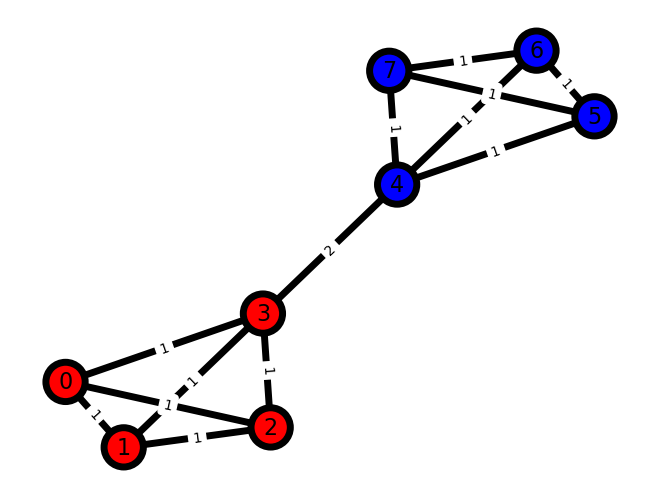

In [54]:
cut_value, (part_1, part_2) = nx.minimum_cut(graph, 0, 5, flow_func=shortest_augmenting_path)
cut_value, part_1, part_2

G_copy = graph.copy(as_view=False)
color_map = []
for node in G_copy:
    if node in part_1:
        color_map.append('red')
    elif node in part_2:
        color_map.append('blue')
    else:
        color_map.append('gray')

DrawGraph(G_copy, color_map)

In [37]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    # output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output



In [40]:
def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 8 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 2,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './final__80wayCut_LossExp16_loss.pth')
model.eval()

logits = net(graph_dgl, q_torch)
logits = override_fixed_nodes(logits)
binary_partitions = (logits >= 0.5).float()
cut = calculateAllCut(q_torch, binary_partitions)
totSum = np.sum(binary_partitions.numpy(), axis=0)
print('cut val:' + str(cut), 'node Sum', totSum)
print("Terminalss: 0-"+ str(binary_partitions[0])+
      " 1-"+ str(binary_partitions[1]))
invalidsCount = [m for m in binary_partitions if sum(m)!=1]
print("Invalids Nodes: " + str( len(invalidsCount)))



cut val:tensor(3., dtype=torch.float64) node Sum [1. 7.]
Terminalss: 0-tensor([1., 0.]) 1-tensor([0., 1.])
Invalids Nodes: 0


## Exp 17

- expriment 17 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss
- training on dataset with 8Experiment 16

In [70]:
def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 8 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 2,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './final__80wayCut_LossExp18_loss.pth')
model.eval()

logits = net(graph_dgl, q_torch)
#logits = override_fixed_nodes(logits)
binary_partitions = (logits >= 0.5).float()
cut = calculateAllCut(q_torch, binary_partitions)
totSum = np.sum(binary_partitions.numpy(), axis=0)
print('cut val:' + str(cut), 'node Sum', totSum)
print("Terminalss: 0-"+ str(binary_partitions[0])+
      " 1-"+ str(binary_partitions[1]))
invalidsCount = [m for m in binary_partitions if sum(m)!=1]
print("Invalids Nodes: " + str( len(invalidsCount)))
print(binary_partitions)



cut val:tensor(1., dtype=torch.float64) node Sum [4. 4.]
Terminalss: 0-tensor([0., 1.]) 1-tensor([0., 1.])
Invalids Nodes: 0
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])


In [76]:
def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 8 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 2,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './final__80wayCut_LossExp19_loss.pth')
model.eval()

logits = net(graph_dgl, q_torch)
#logits = override_fixed_nodes(logits)
binary_partitions = (logits >= 0.5).float()
cut = calculateAllCut(q_torch, binary_partitions)
totSum = np.sum(binary_partitions.numpy(), axis=0)
print('cut val:' + str(cut), 'node Sum', totSum)
print("Terminalss: 0-"+ str(binary_partitions[0])+
      " 1-"+ str(binary_partitions[1]))
invalidsCount = [m for m in binary_partitions if sum(m)!=1]
print("Invalids Nodes: " + str( len(invalidsCount)))
print(binary_partitions)



cut val:tensor(1., dtype=torch.float64) node Sum [4. 4.]
Terminalss: 0-tensor([0., 1.]) 1-tensor([0., 1.])
Invalids Nodes: 0
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])


In [113]:
def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 8 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 2,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './final__80wayCut_LossExp20_loss.pth')
model.eval()

embed = nn.Embedding(8, dim_embedding)
inputs = embed.weight
logits = net(graph_dgl, inputs)
#logits = override_fixed_nodes(logits)
binary_partitions = (logits >= 0.5).float()
cut = calculateAllCut(q_torch, binary_partitions)
totSum = np.sum(binary_partitions.numpy(), axis=0)
print('cut val:' + str(cut), 'node Sum', totSum)
print("Terminalss: 0-"+ str(binary_partitions[0])+
      " 1-"+ str(binary_partitions[1]))
invalidsCount = [m for m in binary_partitions if sum(m)!=1]
print("Invalids Nodes: " + str( len(invalidsCount)))
print(binary_partitions, logits)



cut val:tensor(5., dtype=torch.float64) node Sum [2. 6.]
Terminalss: 0-tensor([0., 1.]) 1-tensor([1., 0.])
Invalids Nodes: 0
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]]) tensor([[2.9220e-04, 9.9971e-01],
        [9.2511e-01, 7.4887e-02],
        [1.8915e-02, 9.8109e-01],
        [9.9979e-01, 2.1081e-04],
        [1.4545e-07, 1.0000e+00],
        [2.4033e-04, 9.9976e-01],
        [3.1601e-01, 6.8399e-01],
        [4.7680e-02, 9.5232e-01]], grad_fn=<SoftmaxBackward0>)


In [134]:
def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 80 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, inputs)
        #logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>0):
            break
testexp1_loss('./final__80wayCut_LossExp21_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(98., dtype=torch.float64) 9.0 4.0 67.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 0., 1.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 



In [7]:
def generate_graph(n, d=None, p=None, graph_type='reg', random_seed=0):
    """
    Helper function to generate a NetworkX random graph of specified type,
    given specified parameters (e.g. d-regular, d=3). Must provide one of
    d or p, d with graph_type='reg', and p with graph_type in ['prob', 'erdos'].

    Input:
        n: Problem size
        d: [Optional] Degree of each node in graph
        p: [Optional] Probability of edge between two nodes
        graph_type: Specifies graph type to generate
        random_seed: Seed value for random generator
    Output:
        nx_graph: NetworkX OrderedGraph of specified type and parameters
    """
    if graph_type == 'reg':
        print(f'Generating d-regular graph with n={n}, d={d}, seed={random_seed}')
        nx_temp = nx.random_regular_graph(d=d, n=n, seed=random_seed)
    elif graph_type == 'reg_random':
        print(f'Generating d-regular random graph with n={n}, d={d}')
        nx_temp = nx.random_regular_graph(d=d, n=n)
    elif graph_type == 'prob':
        print(f'Generating p-probabilistic graph with n={n}, p={p}, seed={random_seed}')
        nx_temp = nx.fast_gnp_random_graph(n, p, seed=random_seed)
    elif graph_type == 'erdos':
        print(f'Generating erdos-renyi graph with n={n}, p={p}, seed={random_seed}')
        nx_temp = nx.erdos_renyi_graph(n, p, seed=random_seed)
    else:
        raise NotImplementedError(f'!! Graph type {graph_type} not handled !!')

    # Networkx does not enforce node order by default
    nx_temp = nx.relabel.convert_node_labels_to_integers(nx_temp)
    # Need to pull nx graph into OrderedGraph so training will work properly
    nx_graph = nx.Graph()
    nx_graph.add_nodes_from(sorted(nx_temp.nodes()))
    nx_graph.add_edges_from(nx_temp.edges)
    nx_graph.order()
    return nx_graph

In [9]:
# nx_generated_graph = {}
#
# for i in range (200):
#     nx_graph = generate_graph(n=80, d=3, p=None, graph_type='reg', random_seed=i)
#
#     for u, v, d in nx_graph.edges(data=True):
#         d['weight'] = 1
#         d['capacity'] = 1
#
#     graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
#     graph_dgl = graph_dgl.to(TORCH_DEVICE)
#     q_torch = qubo_dict_to_torch(nx_graph, gen_adj_matrix(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
#     terminals = [10,40,70]
#     nx_generated_graph[i] = [graph_dgl, q_torch, nx_graph, terminals]

nx_graph = generate_graph(n=80, d=3, p=None, graph_type='reg', random_seed=1)
for u, v, d in nx_graph.edges(data=True):
    d['weight'] = 1
    d['capacity'] = 1
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(nx_graph, gen_adj_matrix(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

Generating d-regular graph with n=80, d=3, seed=1


In [14]:
def hyperParameters(n = 80, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 80 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=80,patience=40)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './final__80MaxwayCut_LossExp1_loss.pth')
model.eval()

logits = net(graph_dgl, q_torch)
#logits = override_fixed_nodes(logits)
binary_partitions = (logits >= 0.5).float()
cut = calculateAllCut(q_torch, binary_partitions)
totSum = np.sum(binary_partitions.numpy(), axis=0)
print('cut val:' + str(cut), 'node Sum', totSum)
print("Terminalss: 0-"+ str(binary_partitions[0])+
      " 1-"+ str(binary_partitions[1]) + " 2-"+ str(binary_partitions[2]))
invalidsCount = [m for m in binary_partitions if sum(m)!=1]
print("Invalids Nodes: " + str( len(invalidsCount)))
print(binary_partitions)



cut val:tensor(106., dtype=torch.float64) node Sum [25. 28. 27.]
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.]) 2-tensor([0., 0., 1.])
Invalids Nodes: 0
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],


In [117]:
# neural_cut = test2()

Neural 2-way min-cut value: 100.0
Neural 2-way min-cut value: 100.0


In [72]:
# heurestic_cut_k = LoadData('./testData/heurestic_cut_k.pkl')
# #

In [55]:
# from matplotlib.ticker import ScalarFormatter
# def barPlot_2(heurestic_cut, neural_cut):
#     # Example data
#     n_groups = len(heurestic_cut)
#     index = np.arange(n_groups)
#     bar_width = 0.35
#
#     # Create bars
#     plt.figure(figsize=(30, 6))
#     bar1 = plt.bar(index, heurestic_cut, bar_width, label='Heurestic')
#     bar2 = plt.bar(index + bar_width, neural_cut, bar_width, label='Neural Network')
#
#     # Add details
#     plt.xlabel('Graph Number')
#     plt.ylabel('Minimum Cut Value')
#     plt.title('Comparison of Minimum Cut Values by Algorithm')
#     # plt.xticks(index + bar_width / 2, range(1, n_groups + 1))
#     plt.legend()
#     # plt.tight_layout()
#     # plt.gca().yaxis.set(major_formatter=ScalarFormatter(), minor_formatter=ScalarFormatter());
#     plt.show()

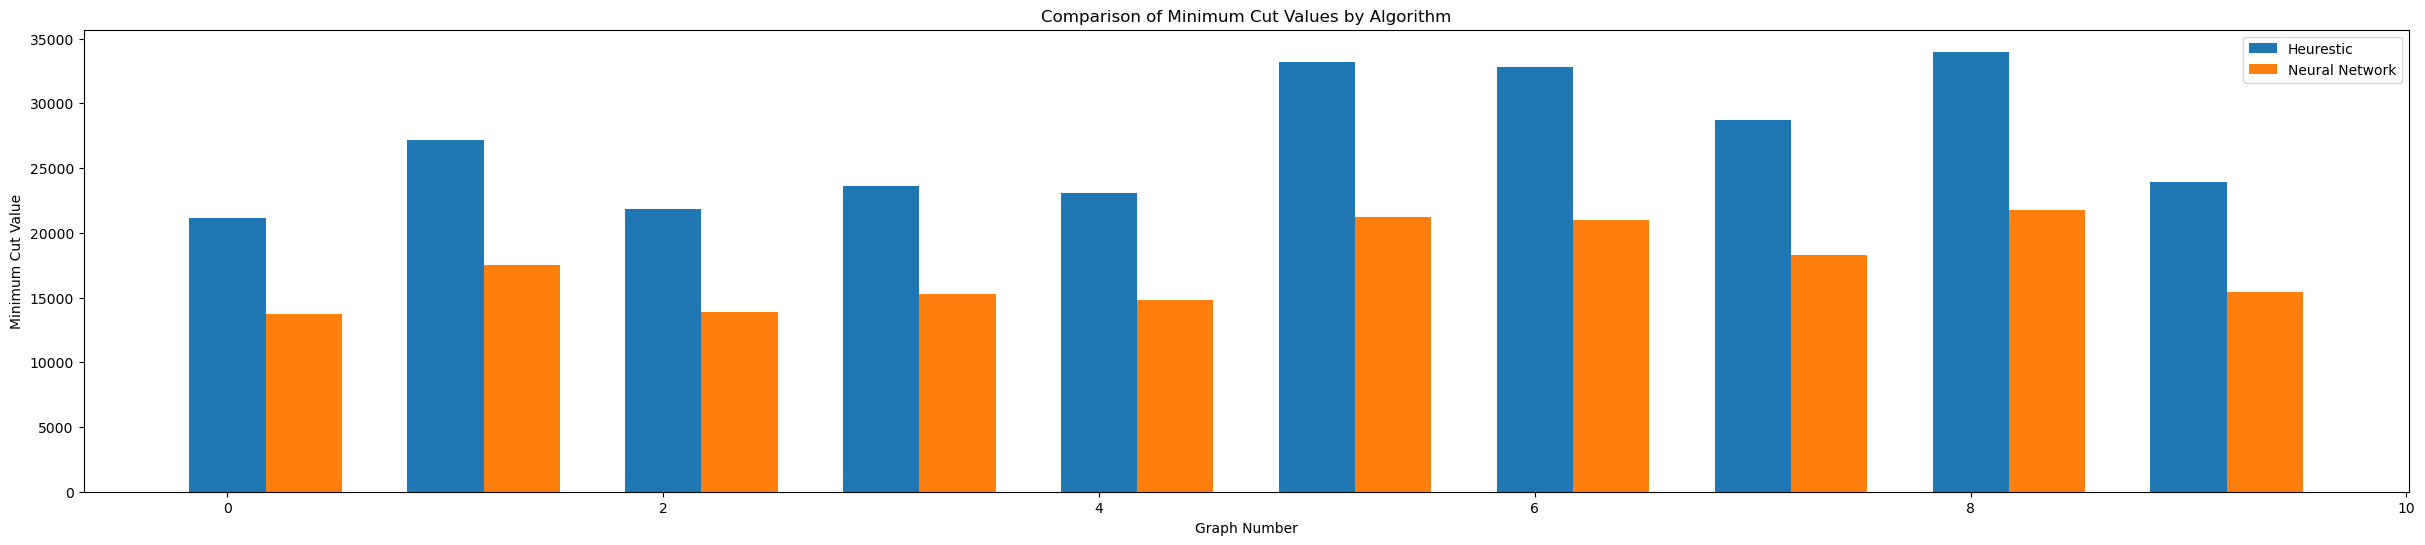

In [56]:
barPlot_2( heurestic_cut_k, neural_cut)